In [1]:
import re
import random
import string
import pandas as pd
import numpy as np

from gensim.models import Word2Vec

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('wordnet')

SEED = 2
random.seed(SEED)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hecto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hecto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def extract_article_data(data):
    pmids = []
    pyears = []
    journals = []
    authors = []
    titles = []
    abstracts = []
    arttypes = []
    langs = []
    
    entries = data.split('\n\n')

    for entry in entries:
        pmid = ''
        pyear = ''
        journal = ''
        authors = ''
        title = ''
        abstract = ''
        arttype = ''
        lang = ''
        
        lines = entry.split('\n')
        abstract_started = False

        for line in lines:
            if re.match(r'^PMID-\s', line):
                pmid = line[re.search(r'-(.*)', line).start() + 1:].strip()
            elif re.match(r'^DP\s\s-\s', line):
                year_match = re.search(r'\d{4}', line)
                if year_match:
                    pyear = year_match.group()
            elif re.match(r'^JT\s\s-\s', line):
                journal = line[re.search(r'-(.*)', line).start() + 1:].strip()
            elif re.match(r'^TI\s\s-\s', line):
                title = line[re.search(r'-(.*)', line).start() + 1:].strip()
            elif re.match(r'^PT\s\s-\s', line):
                arttype = line[re.search(r'-(.*)', line).start() + 1:].strip()
            elif re.match(r'^LA\s\s-\s', line):
                lang = line[re.search(r'-(.*)', line).start() + 1:].strip()
            else:
                if re.match(r'^AB\s\s-\s', line):
                    abstract_started = True
                    abstract += line[re.search(r'-(.*)', line).start() + 1:].strip()
                elif not re.match(r'^\s\s\s\s\s\s', line):
                    if abstract_started:
                        break
                elif abstract_started:
                    abstract += ' ' + line.strip()

        titles.append(title)
        
        if pmid != '':
            pmids.append(pmid)
        else:
            pmids.append('NA')
        
        if pyear != '':
            pyears.append(pyear)
        else:
            pyears.append('NA')
            
        if journal != '':
            journals.append(journal)
        else:
            journals.append('NA')
            
        if lang != '':
            langs.append(lang)
        else:
            langs.append('NA')
            
        if arttype != '':
            arttypes.append(arttype)
        else:
            arttypes.append('NA')

        if abstract != '':
            abstracts.append(abstract)
        else:
            abstracts.append('NA')

    return pmids, titles, pyears, abstracts, arttypes, langs, journals

In [3]:
file_path = 'set3.txt'

with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()
    
data[:500]

'PMID- 33735179\nOWN - NLM\nSTAT- MEDLINE\nDCOM- 20210726\nLR  - 20210726\nIS  - 1545-7885 (Electronic)\nIS  - 1544-9173 (Print)\nIS  - 1544-9173 (Linking)\nVI  - 19\nIP  - 3\nDP  - 2021 Mar\nTI  - Is "bioinformatics" dead?\nPG  - e3001165\nLID - 10.1371/journal.pbio.3001165 [doi]\nLID - e3001165\nAB  - Why would a computational biologist with 40 years of research experience say \n      bioinformatics is dead? The short answer is, in being the Founding Dean of a new \n      School of Data Science, what we do sudd'

In [4]:
pmids, titles, pyears, abstracts, arttypes, langs, journals = extract_article_data(data)

na_column = ['NA' for x in range(len(pmids))]

print(len(arttypes))

print(len(na_column))

article_data = {'PMID': pmids, 'YearPub': pyears, 'Journal': journals, 'Authors': na_column,
                'Title': titles, 'Abstract': abstracts, 'articleType': arttypes, 'language': langs,
               'pmcCitationCount': na_column, 'pmcID': na_column, 'doi': na_column, 'meshTerms': na_column}

article_df = pd.DataFrame(article_data)

article_df.to_csv('article_data.csv')

article_df.head()

2057
2057


,PMID,YearPub,Journal,Authors,Title,Abstract,articleType,language,pmcCitationCount,pmcID,doi,meshTerms
0,33735179,2021,NA,NA,"Is ""bioinformatics"" dead?",Why would a computational biologist with 40 ye...,NA,NA,NA,NA,NA,NA
1,24348234,2013,PLoS computational biology,NA,Education in computational biology today and t...,NA,Editorial,eng,NA,NA,NA,NA
2,28899250,2017,NA,NA,"Again, What Is Nursing Science?","This article again asks, What is nursing scien...",NA,NA,NA,NA,NA,NA
3,23012581,2012,NA,NA,Perspectives on an education in computational ...,The mainstream application of massively parall...,NA,NA,NA,NA,NA,NA
4,33228539,2020,BMC microbiology,NA,Microbiology research at the systems biology a...,NA,Introductory Journal Article,eng,NA,NA,NA,NA


In [5]:
article_df = article_df[article_df['Abstract'] != "NA"]
corpus = article_df['Abstract'].values.astype('U')
corpus[2]

'The mainstream application of massively parallel, high-throughput assays in biomedical research has created a demand for scientists educated in Computational Biology and Bioinformatics (CBB). In response, formalized graduate programs have rapidly evolved over the past decade. Concurrently, there is increasing need for clinicians trained to oversee the responsible translation of CBB research into clinical tools. Physician-scientists with dedicated CBB training can facilitate such translation, positioning themselves at the intersection between computational biomedical research and medicine. This perspective explores key elements of the educational path to such a position, specifically addressing: 1) evolving perceptions of the role of the computational biologist and the impact on training and career opportunities; 2) challenges in and strategies for obtaining the core skill set required of a biomedical researcher in a computational world; and 3) how the combination of CBB with medical t

In [6]:
Lemmatizer = WordNetLemmatizer()

custom_stopwords = set(stopwords.words("english")+ ["study", "group", "patient", "used", 
                                                     "disease", "effect", "method", "also",
                                                     "result", "two", "may","level",
                                                     "participant","treatment","associated"
                                                    "risk", "however","year",
                                                     "the", "this","using", "showed", "analysis","text",
                                                    "abstract","figure", "article", "genomics",
                                                   "student", "research", "genetic", "bioinformatics",
                                                   "bioinformatic", "health", "biology", "science",
                                                   "genomic", "data", "education", "genetics", 
                                                   "gene", "genome", "nursing", "knowledge", "information"])

custom_stopwords = [Lemmatizer.lemmatize(word) for word in custom_stopwords]

In [7]:
def clean_text(corpus):
    abstracts =[]
    for line in corpus:
        line.replace("\n", "")
        line = line.lower()
        line = line.translate(str.maketrans('', '', string.punctuation))
        line = re.sub('[^A-Za-z]', ' ', line)
        new = ' '
        for word in line.split():
            word = Lemmatizer.lemmatize(word)
            if word not in custom_stopwords and len(word)>3:
                new = new + ' ' + word
        abstracts.append(new)
    return abstracts

In [8]:
abstract_list = clean_text(corpus)

abstract_list[2]

'  mainstream application massively parallel highthroughput assay biomedical created demand scientist educated computational response formalized graduate program rapidly evolved past decade concurrently increasing need clinician trained oversee responsible translation clinical tool physicianscientists dedicated training facilitate translation positioning intersection computational biomedical medicine perspective explores element educational path position specifically addressing evolving perception role computational biologist impact training career opportunity challenge strategy obtaining core skill required biomedical researcher computational world combination medical training provides logical foundation career academic medicine andor biomedical'

In [9]:
def tokenizer(abst_list):
    abstract_tokens =[]
    for line in abst_list:
        tokens = word_tokenize(line)
        tokens = [t for t in tokens if len(t) > 3]
        abstract_tokens.append(tokens)
    return abstract_tokens

In [10]:
abstract_tokens = tokenizer(abstract_list)

model = Word2Vec(sentences=abstract_tokens, workers=1, seed=SEED)

In [11]:
def vectorize(list_of_docs, model):
  features = []

  for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
  return features

vectorized_docs = vectorize(abstract_tokens, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(1381, 100)

In [12]:
range_n_clusters = list(range(2,11))
clusters = []
n_cluster = []
inertia_vals = []

for n_clusters in range_n_clusters:
  cluster_model = KMeans(n_clusters=n_clusters, random_state=5)
  cluster_model.fit(vectorized_docs)

  clusters.append(cluster_model)
  inertia_vals.append(cluster_model.inertia_)
  n_cluster.append(n_clusters)

range_n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

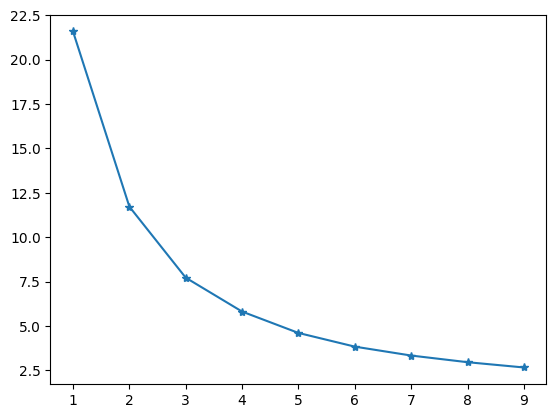

In [13]:
plt.plot(range(1,10,1),inertia_vals,marker='*')
plt.show()

In [14]:
for i in range(0,9,1):
  print("----------------------")
  print('cluster',n_cluster[i])
  print(clusters[i])
  print("Silhouette score: ", silhouette_score(vectorized_docs,clusters[i].predict(vectorized_docs)))

----------------------
cluster 2
KMeans(n_clusters=2, random_state=5)
Silhouette score:  0.5305009
----------------------
cluster 3
KMeans(n_clusters=3, random_state=5)
Silhouette score:  0.48484808
----------------------
cluster 4
KMeans(n_clusters=4, random_state=5)
Silhouette score:  0.4566969
----------------------
cluster 5
KMeans(n_clusters=5, random_state=5)
Silhouette score:  0.42089215
----------------------
cluster 6
KMeans(n_clusters=6, random_state=5)
Silhouette score:  0.41275746
----------------------
cluster 7
KMeans(n_clusters=7, random_state=5)
Silhouette score:  0.3937364
----------------------
cluster 8
KMeans(random_state=5)
Silhouette score:  0.3831603
----------------------
cluster 9
KMeans(n_clusters=9, random_state=5)
Silhouette score:  0.35151306
----------------------
cluster 10
KMeans(n_clusters=10, random_state=5)
Silhouette score:  0.34941354


In [15]:
k = 3

k_means = KMeans(n_clusters=k, random_state=5)
k_means.fit(vectorized_docs)

KMeans(n_clusters=3, random_state=5)

In [16]:
pca = PCA(n_components=3, random_state=5)

reduced_vectors = pca.fit_transform(vectorized_docs)
reduced_clusters = pca.fit_transform(k_means.cluster_centers_)

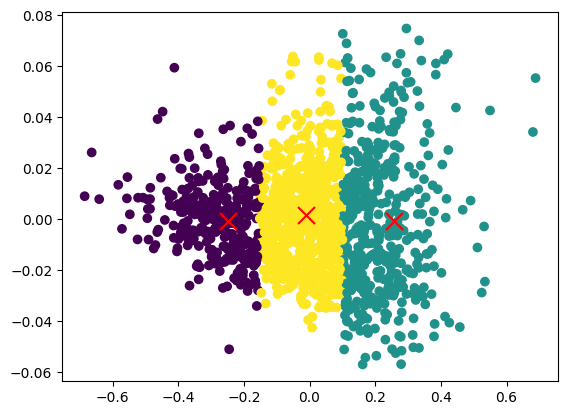

In [17]:
plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_)
plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

In [18]:
article_df['preprocessed_abstract'] = abstract_list
article_df['labels'] = k_means.labels_
article_df['labels'].value_counts()

labels
2    631
1    448
0    302
Name: count, dtype: int64

In [19]:
def get_top_n_words(corpus, n):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [20]:
def get_wordcloud(text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

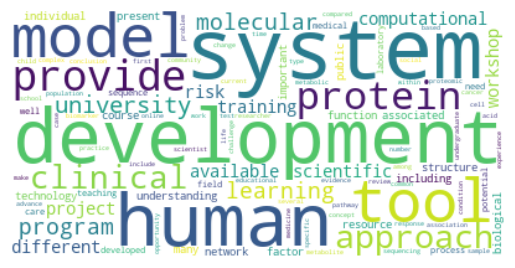

Top 10 words from cluster 0 :
['system', 'development', 'human', 'model', 'tool', 'protein', 'approach', 'clinical', 'university', 'program']


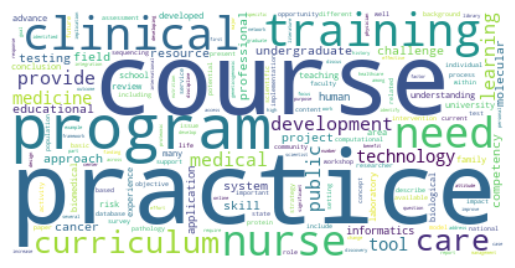

Top 10 words from cluster 1 :
['practice', 'course', 'program', 'training', 'clinical', 'nurse', 'need', 'curriculum', 'care', 'development']


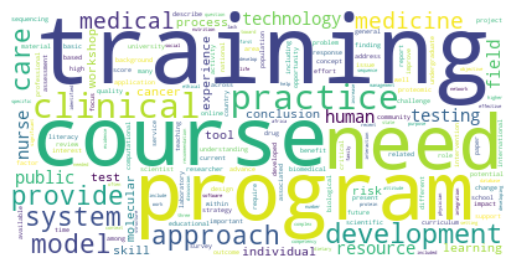

Top 10 words from cluster 2 :
['training', 'course', 'program', 'need', 'practice', 'clinical', 'development', 'approach', 'care', 'system']


In [21]:
for clus in range (3):
    text =' '
    df2 = article_df.loc[article_df["labels"]==clus]
    
    for abst in df2.preprocessed_abstract:
        text += abst
    get_wordcloud(text)
    
    words = []
    for i, j in get_top_n_words(df2["preprocessed_abstract"],10):
        words.append(i)
    print ("Top 10 words from cluster",clus,":")
    print (words)

In [22]:
article_df[article_df['labels']==0]

,PMID,YearPub,Journal,Authors,Title,Abstract,articleType,language,pmcCitationCount,pmcID,doi,meshTerms,preprocessed_abstract,labels
6,28661353,2016,NA,NA,SystemsX.ch.,SystemsX. ch has the objective of supporting a...,NA,NA,NA,NA,NA,NA,systemsx objective supporting promoting para...,0
8,33997009,2021,NA,NA,Status of Bioinformatics Education in South As...,Bioinformatics education has been a hot topic ...,NA,NA,NA,NA,NA,NA,topic south asia interest peak start century...,0
11,33648321,2021,NA,NA,COBRE for Computational Biology of Human Disea...,We provide a program update on the COBRE Cente...,NA,NA,NA,NA,NA,NA,provide program update cobre center computat...,0
20,27556295,2016,NA,NA,Intelligent biology and medicine in 2015: adva...,We summarize the 2015 International Conference...,NA,NA,NA,NA,NA,NA,summarize international conference intellige...,0
23,29543809,2018,NA,NA,Meet-U: Educating through research immersion.,We present a new educational initiative called...,NA,NA,NA,NA,NA,NA,present educational initiative called meetu ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,31822566,2019,NA,NA,Computational microscopy: Revealing molecular ...,plantcell;31/12/tpc.119.tt1219/FIG1F1fig1Struc...,NA,NA,NA,NA,NA,NA,plantcell structural provided valuable insig...,0
2042,30951675,2019,NA,NA,The Responsibility to Recontact Research Parti...,The evidence base supporting genetic and genom...,NA,NA,NA,NA,NA,NA,evidence base supporting sequencevariant int...,0
2049,27459981,2016,NA,NA,Pediatric Oncology Provider Views on Performin...,BACKGROUND: Patients with relapsed and refract...,NA,NA,NA,NA,NA,NA,background relapsed refractory solid tumor p...,0
2050,29852774,2018,NA,NA,Clinical potential of meningioma genomic insig...,Meningiomas are among the most common intracra...,NA,NA,NA,NA,NA,NA,meningioma among common intracranial patholo...,0


In [23]:
article_df[article_df['labels']==1]

,PMID,YearPub,Journal,Authors,Title,Abstract,articleType,language,pmcCitationCount,pmcID,doi,meshTerms,preprocessed_abstract,labels
0,33735179,2021,NA,NA,"Is ""bioinformatics"" dead?",Why would a computational biologist with 40 ye...,NA,NA,NA,NA,NA,NA,would computational biologist experience dea...,1
3,23012581,2012,NA,NA,Perspectives on an education in computational ...,The mainstream application of massively parall...,NA,NA,NA,NA,NA,NA,mainstream application massively parallel hi...,1
21,25829469,2016,NA,NA,Adapting bioinformatics curricula for big data.,Modern technologies are capable of generating ...,NA,NA,NA,NA,NA,NA,modern technology capable generating enormou...,1
24,21405201,2011,NA,NA,Teaching systems biology.,Advances in systems biology are increasingly d...,NA,NA,NA,NA,NA,NA,advance system increasingly dependent upon i...,1
28,30489214,2019,NA,NA,From helices to health: undergraduate medical ...,Rapid advances in genomic technologies combine...,NA,NA,NA,NA,NA,NA,rapid advance technology combined drastic re...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,16458178,2006,NA,NA,Cancer screening in older adults in an era of ...,OBJECTIVES: To provide an overview of cancer g...,NA,NA,NA,NA,NA,NA,objective provide overview cancer cancer scr...,1
2024,9629453,1998,NA,NA,Genetics in the OR--implications for periopera...,New developments in deoxyribonucleic acid (DNA...,NA,NA,NA,NA,NA,NA,development deoxyribonucleic acid technology...,1
2030,15491025,2004,NA,NA,Clinical applications of genetics in sporadic ...,OBJECTIVES: To describe how genetic informatio...,NA,NA,NA,NA,NA,NA,objective describe shape understanding carci...,1
2031,10321677,1999,NA,NA,Molecular biology for the critical care physic...,The past few years have seen a profound revolu...,NA,NA,NA,NA,NA,NA,past seen profound revolution biological eno...,1


In [24]:
article_df[article_df['labels']==2]

,PMID,YearPub,Journal,Authors,Title,Abstract,articleType,language,pmcCitationCount,pmcID,doi,meshTerms,preprocessed_abstract,labels
2,28899250,2017,NA,NA,"Again, What Is Nursing Science?","This article again asks, What is nursing scien...",NA,NA,NA,NA,NA,NA,asks know care author describes threat survi...,2
9,32399760,2020,NA,NA,Meeting the Needs of A Changing Landscape: Adv...,"Over the last 25 years, reforms in undergradua...",NA,NA,NA,NA,NA,NA,last reform undergraduate transformed taught...,2
10,19958508,2009,NA,NA,Towards a career in bioinformatics.,The 2009 annual conference of the Asia Pacific...,NA,NA,NA,NA,NA,NA,annual conference asia pacific network apbio...,2
12,34591953,2022,NA,NA,Bioinformatics mentorship in a resource limite...,BACKGROUND: The two recent simultaneous develo...,NA,NA,NA,NA,NA,NA,background recent simultaneous development h...,2
13,31347084,2019,NA,NA,Recent Applications of Mass Spectrometry at Cl...,Mass spectrometry (MS) is a powerful technique...,NA,NA,NA,NA,NA,NA,mass spectrometry powerful technique various...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,12674396,2003,NA,NA,"Attitudes toward genetic testing: gender, role...","As a result of the Human Genome Project, genet...",NA,NA,NA,NA,NA,NA,human project testing could availability det...,2
2041,27510539,2016,NA,NA,The effect of the apolipoprotein E genotype on...,BACKGROUND: The apolipoprotein E (APOE) risk a...,NA,NA,NA,NA,NA,NA,background apolipoprotein apoe risk allele a...,2
2053,16401061,2005,NA,NA,Understanding genetics: a primer for occupatio...,Because biologic diversity is essential for li...,NA,NA,NA,NA,NA,NA,biologic diversity essential life developed ...,2
2054,31311603,2019,NA,NA,Beyond the hype of big data and artificial int...,"Big data, coupled with the use of advanced ana...",NA,NA,NA,NA,NA,NA,coupled advanced analytical approach artific...,2
